In [1]:
import pandas as pd
import numpy as np
path = '../data/'
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
viz_path = '../viz/'
from utils import *
from network import *
from geo_exploration import *

In [40]:
df = load_data(path)
df = preprocess(df)



/Users/caom/Documents/CausalLens_TakeHome/src/utils.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ended_at'] = pd.to_datetime(df['ended_at'], format='ISO8601')
/Users/caom/Documents/CausalLens_TakeHome/src/utils.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_started'] = df['started_at'].dt.year
/Users/caom/Documents/CausalLens_TakeHome/src/utils.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [3]:
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,hour_started,minute_started,second_started,year_ended,month_ended,day_ended,weekday_ended,hour_ended,minute_ended,second_ended
295082,11AA3AB3ED9FEFC5,classic_bike,2022-01-01 00:10:20,2022-01-01 00:19:29,Riverview Park,JC057,Riverview Park,JC057,40.744319,-74.043991,...,0,10,20,2022,1,1,5,0,19,29
312873,554FD61E00599BE2,electric_bike,2022-01-01 00:10:24,2022-01-01 00:14:06,Sip Ave,JC056,Glenwood Ave,JC094,40.730897,-74.063913,...,0,10,24,2022,1,1,5,0,14,6
312934,4D3D324F756B7103,electric_bike,2022-01-01 00:10:28,2022-01-01 00:14:12,Sip Ave,JC056,Glenwood Ave,JC094,40.730897,-74.063913,...,0,10,28,2022,1,1,5,0,14,12
295511,E26BB19DBC834216,classic_bike,2022-01-01 00:10:30,2022-01-01 00:24:30,Grove St PATH,JC005,Newport Pkwy,JC008,40.719586,-74.043117,...,0,10,30,2022,1,1,5,0,24,30
298413,DC18B042AA415411,classic_bike,2022-01-01 00:11:31,2022-01-01 00:30:43,Columbus Dr at Exchange Pl,JC106,Columbus Dr at Exchange Pl,JC106,40.716870,-74.032810,...,0,11,31,2022,1,1,5,0,30,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49840,B41EB02871B99E34,classic_bike,2024-04-30 23:36:20,2024-04-30 23:38:15,Newark Ave,JC032,Jersey & 6th St,JC027,40.721525,-74.046305,...,23,36,20,2024,4,30,1,23,38,15
39859,AD14D110757EAC72,electric_bike,2024-04-30 23:41:50,2024-04-30 23:46:59,9 St HBLR - Jackson St & 8 St,HB305,Church Sq Park - 5 St & Park Ave,HB601,40.748099,-74.038417,...,23,41,50,2024,4,30,1,23,46,59
40621,CF187C42DFB29698,electric_bike,2024-04-30 23:41:55,2024-04-30 23:47:04,9 St HBLR - Jackson St & 8 St,HB305,Church Sq Park - 5 St & Park Ave,HB601,40.747993,-74.038469,...,23,41,55,2024,4,30,1,23,47,4
48338,D4E42712B36E3DEF,classic_bike,2024-04-30 23:48:53,2024-04-30 23:50:35,Newark Ave,JC032,Van Vorst Park,JC035,40.721525,-74.046305,...,23,48,53,2024,4,30,1,23,50,35


In [4]:

def spatial_demand_extraction(df):
    # Create outgoing bikes data
    outgoing = df.groupby(['start_station_name', 'year_started', 'month_started', 'weekday_started', 'hour_started']).size().reset_index(name='outgoing_bikes')

    # Create incoming bikes data
    incoming = df.groupby(['end_station_name', 'year_ended', 'month_ended', 'weekday_ended', 'hour_ended']).size().reset_index(name='incoming_bikes')
 
    outgoing.rename(columns={'start_station_name': 'station_name', 'year_started': 'year', 'month_started': 'month', 'weekday_started': 'weekday', 'hour_started': 'hour'}, inplace=True)
    incoming.rename(columns={'end_station_name': 'station_name', 'year_ended': 'year', 'month_ended': 'month', 'weekday_ended': 'weekday', 'hour_ended': 'hour'}, inplace=True)

    # Merge the dataframes
    demand = pd.merge(outgoing, incoming, how='outer', on=['station_name', 'year', 'month', 'weekday', 'hour'])
    demand.fillna(0, inplace=True)
    demand['net_bikes'] = demand['incoming_bikes'] - demand['outgoing_bikes']
    
    return demand

def temporal_demand_extraction(df):
    demand = df.groupby(['year_started','month_started','weekday_started','hour_started']).size().reset_index(name='count')
    demand = demand.groupby(['year_started','month_started','weekday_started']).agg({'count': 'max'}).reset_index()
    demand.rename(columns={'year_started': 'year', 'month_started': 'month', 'weekday_started': 'weekday', 'hour_started': 'hour'}, inplace=True)
    return demand
    


Results of Dickey-Fuller Test:
Test Statistic                  -3.167443
p-value                          0.021948
#Lags Used                      15.000000
Number of Observations Used    180.000000
Critical Value (1%)             -3.467211
Critical Value (5%)             -2.877735
Critical Value (10%)            -2.575403
dtype: float64


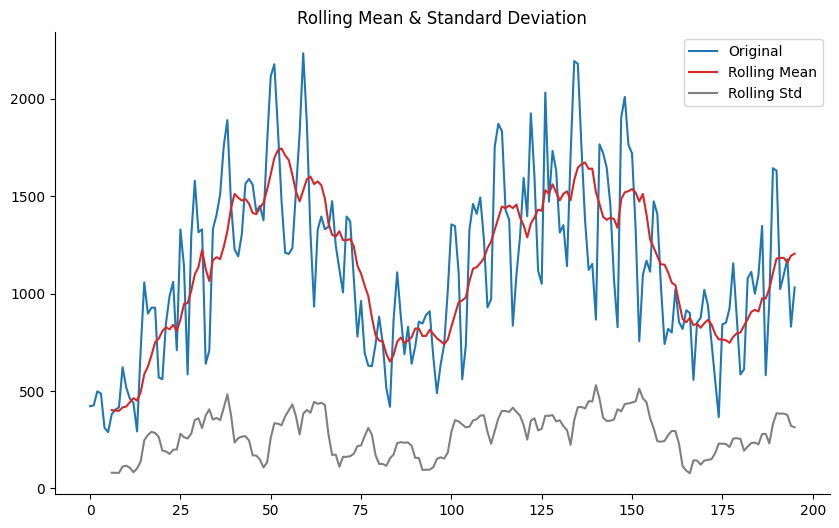

In [5]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

demand = temporal_demand_extraction(df)

# Perform stationarity test
test_stationarity(demand['count'])

# Plotting rolling statistics:
rolmean = demand['count'].rolling(window=7).mean()  # window can be adjusted
rolstd = demand['count'].rolling(window=7).std()

plt.figure(figsize=(10, 6))
plt.plot(demand['count'], color='Tab:blue', label='Original')
plt.plot(rolmean, color='Tab:red', label='Rolling Mean')
plt.plot(rolstd, color='gray', label='Rolling Std')
plt.legend(loc='best')
sns.despine()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

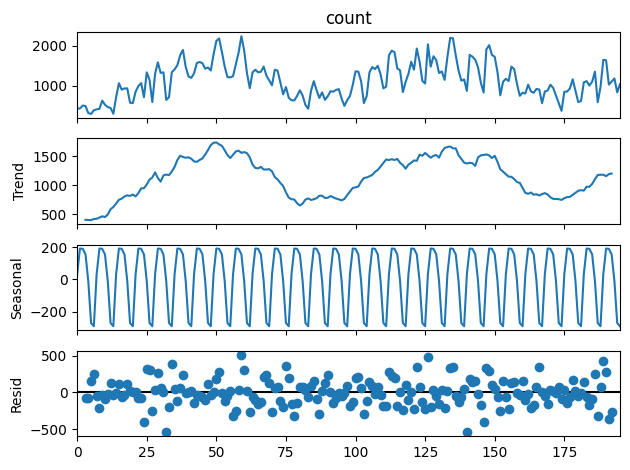

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(demand['count'], model='additive', period=7)  
result.plot()
plt.show()

In [15]:
from tbats import TBATS
import matplotlib.pyplot as plt

demand

# Assuming 'bike_count' is the column with the data you want to model
train_size = int(len(demand) * 0.7)
train, test = demand['count'][:train_size], demand['count'][train_size:]
# Create a TBATS estimator specifying the seasonal periods
# Here you need to know your data's seasonal periods, e.g., 24 hours, 7 days
estimator = TBATS(seasonal_periods=[7, 7*12])

# Fit the model
model = estimator.fit(train)

# Summarize model effects
print(model.summary())

# Forecast future values, e.g., forecast the next 48 hours
tbats_fitted = model.y_hat
tbats_forecasts = model.forecast(steps=len(test))


Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [ 7. 84.]
Seasonal harmonics [ 2 11]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.098157
Seasonal Parameters (Gamma): [-0.00950239 -0.00510511 -0.01358872  0.00474184]
AR coefficients []
MA coefficients []
Seed vector [ 9.28307427e+02 -6.42484568e+01  4.84468964e+01  2.39213544e+02
  3.45005074e+01 -4.62644054e+02 -9.33363255e+01  4.16419713e+00
 -9.20629816e-02  1.75325272e+01  1.97764630e+01  4.62279546e+01
 -4.90016664e+01 -1.86272959e+01  5.99232268e+01  1.34897810e+01
 -1.67111701e+02  2.21633506e+01  4.00397602e+00  3.79529579e+01
  2.61152862e+01  1.45488789e+01  5.30958784e+01 -1.00168798e+02
  4.22192289e+01  7.28305460e+00 -1.04964377e+02]

AIC 2120.339860


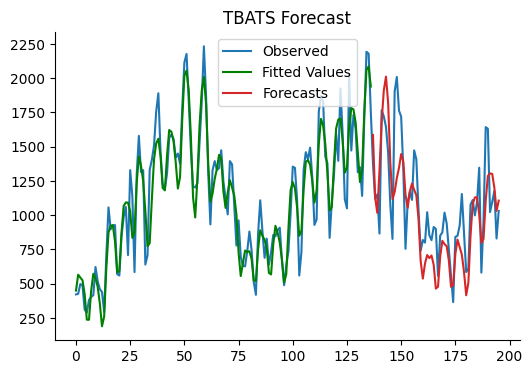

In [20]:
# Plotting the results
plt.figure(figsize=(6, 4))
plt.plot(demand['count'], label='Observed')

fitted_values = model.y_hat
original_index = range(len(train))
forecast_index = range(len(train), len(train) + len(test))

plt.plot(original_index, tbats_fitted, label='Fitted Values', color='green')
plt.plot(forecast_index, tbats_forecasts, label='Forecasts', color='Tab:red')


plt.title('TBATS Forecast')
plt.legend()
sns.despine()
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# TBATS metrics
tbats_mae = mean_absolute_error(test, tbats_forecasts)
tbats_rmse = np.sqrt(mean_squared_error(test, tbats_forecasts))
tbats_mape = np.mean(np.abs((test - tbats_forecasts) / test)) * 100

print("TBATS MAE:", tbats_mae)
print("TBATS RMSE:", tbats_rmse)
print("TBATS MAPE:", tbats_mape)

TBATS MAE: 215.1200685827108
TBATS RMSE: 268.8749659615851
TBATS MAPE: 20.094601026910187


In [21]:
demand

,year,month,weekday,count
0,2022,1,0,422
1,2022,1,1,426
2,2022,1,2,498
3,2022,1,3,487
4,2022,1,4,311
...,...,...,...,...
191,2024,4,2,1023
192,2024,4,3,1097
193,2024,4,4,1177
194,2024,4,5,830


In [23]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'year_started', 'month_started', 'day_started',
       'weekday_started', 'hour_started', 'minute_started', 'second_started',
       'year_ended', 'month_ended', 'day_ended', 'weekday_ended', 'hour_ended',
       'minute_ended', 'second_ended'],
      dtype='object')

In [92]:
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import GridSearchCV
demand = temporal_demand_extraction(df)

# Generate lag features
for lag in range(1, 8):
    demand[f'lag_{lag}'] = demand['count'].shift(lag)

# Drop NA values created by lag features
demand.dropna(inplace=True)

# Re-split with lagged data
train_size = int(len(demand) * 0.8)
train, test = demand[:train_size], demand[train_size:]


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'reg_alpha': [0, 0.1, 0.5],   # L1 regularization
    'reg_lambda': [1, 1.5, 2]     # L2 regularization
}


# Initialize the XGBoost regressor
xgb_model = XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Negative MSE (minimize MSE)
    cv=3,                              # 3-fold cross-validation
    verbose=1,
    n_jobs=-1                          # Use all available cores
)

# Prepare X and y for training
X_train = train.drop(['count'], axis=1)
y_train = train['count']
X_test = test.drop(['count'], axis=1)
y_test = test['count']

# Assuming X_train and y_train are your features and target
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE (negated): ", np.sqrt(-grid_search.best_score_))


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 2, 'subsample': 1}
Best RMSE (negated):  255.94361024985182


/Users/caom/miniconda3/envs/citibike/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [95]:
# Retrieve the best model from grid search
best_model = grid_search.best_estimator_
# Make predictions on the training and test sets
xgb_fitted = best_model.predict(X_train)
xgb_forecast = best_model.predict(X_test)

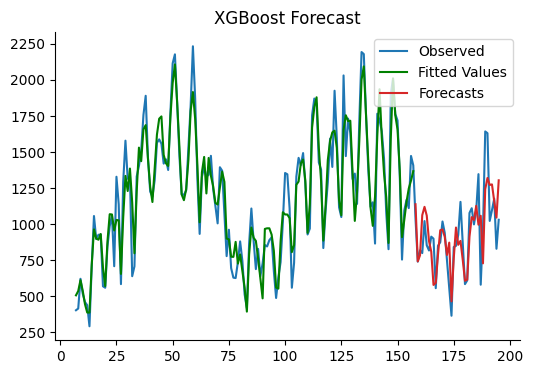

In [96]:
# Plotting the results
plt.figure(figsize=(6, 4))
plt.plot(demand['count'], label='Observed')


original_index = train.index
forecast_index = test.index

plt.plot(original_index, xgb_fitted, label='Fitted Values', color='green')
plt.plot(forecast_index, xgb_forecast, label='Forecasts', color='Tab:red')


plt.title('XGBoost Forecast')
plt.legend()
sns.despine()
plt.show()

In [97]:
# XGBoost metrics
xgb_mae = mean_absolute_error(y_test, xgb_forecast)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_forecast))
xgb_mape = np.mean(np.abs((y_test - xgb_forecast) / y_test)) * 100

print("XGBoost MAE:", xgb_mae)
print("XGBoost RMSE:", xgb_rmse)
print("XGBoost MAPE:", xgb_mape)

XGBoost MAE: 147.2685089111328
XGBoost RMSE: 192.0664042086108
XGBoost MAPE: 16.500466636393167


In [99]:
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import GridSearchCV
demand = temporal_demand_extraction(df)


# Drop NA values created by lag features
demand.dropna(inplace=True)

# Re-split with lagged data
train_size = int(len(demand) * 0.8)
train, test = demand[:train_size], demand[train_size:]


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'reg_alpha': [0, 0.1, 0.5],   # L1 regularization
    'reg_lambda': [1, 1.5, 2]     # L2 regularization
}


# Initialize the XGBoost regressor
xgb_model = XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Negative MSE (minimize MSE)
    cv=3,                              # 3-fold cross-validation
    verbose=1,
    n_jobs=-1                          # Use all available cores
)

# Prepare X and y for training
X_train = train.drop(['count'], axis=1)
y_train = train['count']
X_test = test.drop(['count'], axis=1)
y_test = test['count']

# Assuming X_train and y_train are your features and target
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE (negated): ", np.sqrt(-grid_search.best_score_))


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.8}
Best RMSE (negated):  272.4202898138822


In [100]:
# Retrieve the best model from grid search
best_model = grid_search.best_estimator_
# Make predictions on the training and test sets
xgb_fitted = best_model.predict(X_train)
xgb_forecast = best_model.predict(X_test)

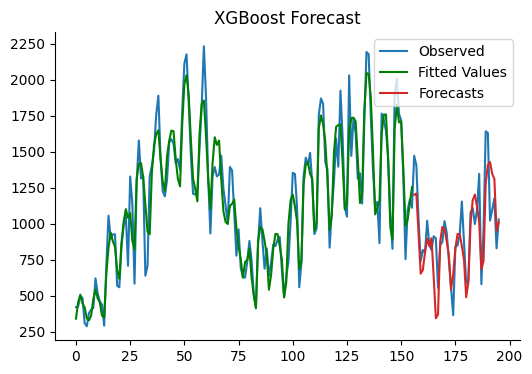

In [101]:
# Plotting the results
plt.figure(figsize=(6, 4))
plt.plot(demand['count'], label='Observed')


original_index = train.index
forecast_index = test.index

plt.plot(original_index, xgb_fitted, label='Fitted Values', color='green')
plt.plot(forecast_index, xgb_forecast, label='Forecasts', color='Tab:red')


plt.title('XGBoost Forecast')
plt.legend()
sns.despine()
plt.show()

In [103]:
# XGBoost metrics
xgb_mae = mean_absolute_error(y_test, xgb_forecast)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_forecast))
xgb_mape = np.mean(np.abs((y_test - xgb_forecast) / y_test)) * 100

print("XGBoost MAE:", xgb_mae)
print("XGBoost RMSE:", xgb_rmse)
print("XGBoost MAPE:", xgb_mape)

XGBoost MAE: 144.62927017211913
XGBoost RMSE: 192.48900666734994
XGBoost MAPE: 15.711701201501697
